#Diabetic Retinopathy Identification

# Install Libraries and Datasets

In [ ]:
# Installing libraries

import tensorflow as tf
import random, os
import shutil
from matplotlib.image import imread
import sklearn
from sklearn.model_selection import train_test_split
import os
import random
import numpy as np
import pandas as pd
import cv2
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.mobilenet import MobileNet
from keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Installing datasets

# Installing the diabetic retinopathy data set
!wget https://www.dropbox.com/s/8qigh2prdf116a3/dr224.zip?dl=0

--2023-03-17 01:25:23--  https://www.dropbox.com/s/8qigh2prdf116a3/dr224.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8qigh2prdf116a3/dr224.zip [following]
--2023-03-17 01:25:24--  https://www.dropbox.com/s/raw/8qigh2prdf116a3/dr224.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c8154a20f4550298d18782258.dl.dropboxusercontent.com/cd/0/inline/B4ZwsXKwvMzRtgop3Tgx121BTz7bkzD4Il7nNgHXYkQjdAtXh11NYYRHKXZjNhpZvK6jf0hRLMZKW7PdvH6cPvfLEhylDp_ZyEjxAcJ6jBmACZV1XhI0JK1pvqEI-ntqkBsZb4pcZiLc0JrSZEmFGhXoIVp7M0YWd6W7JQ2ioub2Ow/file# [following]
--2023-03-17 01:25:24--  https://uc6c8154a20f4550298d18782258.dl.dropboxusercontent.com/cd/0/inline/B4ZwsXKwvMzRtgop3Tgx121BTz7bkzD4Il7nNgHXYkQjdAtXh11NYYRHKXZjNhpZvK6jf0hRLMZKW7PdvH6c

In [ ]:
#Unzip the dataset

!unzip dr224.zip?dl=0

# Data Exploration & Management


In [ ]:
# Create an empty list to store the images
healthy_list = []
moderate_list = []
severe_list = []
proliferate_list = []

# Get the list of files in the directory
healthy_files = os.listdir('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR')
moderate_files = os.listdir('/content/gaussian_filtered_images/gaussian_filtered_images/Moderate')
severe_files = os.listdir('/content/gaussian_filtered_images/gaussian_filtered_images/Severe')
proliferate_files = os.listdir('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR')

# Iterate over the files and append them to the healthy_list
for file in healthy_files:
    file_path = os.path.join('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR', file)
    healthy_list.append(imageio.imread(file_path))

# Iterate over the files and append them to the moderate_list
for file in moderate_files:
    file_path = os.path.join('/content/gaussian_filtered_images/gaussian_filtered_images/Moderate', file)
    moderate_list.append(imageio.imread(file_path))

# Iterate over the files and append them to the severe_list
for file in severe_files:
    file_path = os.path.join('/content/gaussian_filtered_images/gaussian_filtered_images/Severe', file)
    severe_list.append(imageio.imread(file_path))

# Iterate over the files and append them to the proliferate_list
for file in proliferate_files:
    file_path = os.path.join('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR', file)
    proliferate_list.append(imageio.imread(file_path))

# Convert the list of images to a NumPy array
healthy_array = np.array(healthy_list)
moderate_array = np.array(moderate_list)
severe_array = np.array(severe_list)
proliferate_array = np.array(proliferate_list)

In [ ]:
# Binary code for the list: 0 = no_dr, 1 = dr

moderate_copy = moderate_array
random.shuffle(moderate_copy)

moderate_copy_half = moderate_copy[:len(moderate_copy) // 2]

yes_dr1 = np.concatenate((moderate_copy_half, severe_array, proliferate_array))


#toning down the size of the healthy array from 1804 to 987 to equal the combined size of the yes_dr1 array
healthy_copy = healthy_array
random.shuffle(healthy_copy)

healthy_copy_half = healthy_copy[0:987]

no_dr0 = healthy_copy_half

In [ ]:
# Combine the arrays
combined_array = np.concatenate([no_dr0, yes_dr1])

# Create a label array with the binary labels
zeroes = np.zeros(987)
ones = np.ones(987)
label_array = np.concatenate([zeroes, ones])

In [ ]:
# Verifying that all images are the same size -- 224 x 224

same_size = True
reference_shape = combined_array[0].shape
for i in range(1, len(combined_array)):
    if combined_array[i].shape != reference_shape:
        same_size = False
        break

if same_size:
    print("All images are the same size")

    height, width = combined_array.shape[:2]
    print("Image size: {} x {}".format(height, width))
else:
    print("Not all images are the same size")

All images are the same size
Image size: 1974 x 224


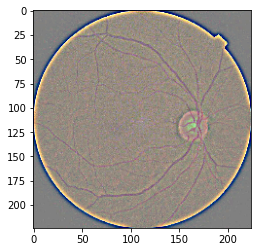

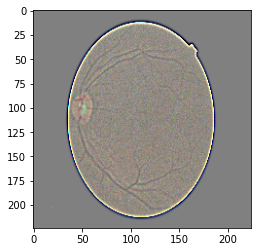

In [ ]:
# Printing out a few image examples

plt.imshow(combined_array[1])
plt.show()

plt.imshow(combined_array[467])
plt.show()

In [ ]:
# Download Some Images For Testing

number = 1022

cv2.imwrite('yes.jpg', combined_array[number])

True

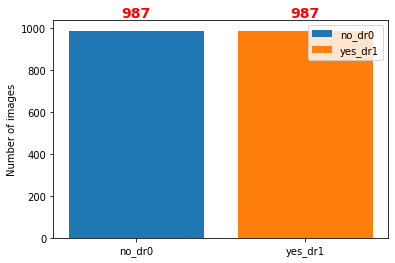

In [ ]:
# Matplotlib Bar Graph Construction -- Verify Balanced Dataset

# Count the number of no_dr0 and yes_dr1 images in the combined_array
num_no_dr0 = no_dr0.shape[0]
num_yes_dr1 = yes_dr1.shape[0]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar plot with two bars, one for no_dr0 and one for yes_dr1
ax.bar(0, num_no_dr0, label="no_dr0")
ax.bar(1, num_yes_dr1, label="yes_dr1")

# Set the x-axis tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["no_dr0", "yes_dr1"])

# Set the y-axis tick labels
ax.set_ylabel("Number of images")

# Add labels to the bar graphs
ax.text(0, num_no_dr0 + 50, str(num_no_dr0), ha="center", va="bottom", fontsize=14, color="red", weight="bold")
ax.text(1, num_yes_dr1 + 50, str(num_yes_dr1), ha="center", va="bottom", fontsize=14, color="red", weight="bold")

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Prepare for TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/

#Machine Learning Algorithm


In [ ]:
# Necessary imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the features and labels from the combined_array_2D array:
X = combined_array # features (colored images)
y = label_array # labels (diagnosis of DR)

# Reshape the features to have 4 dimensions (batch_size, height, width, channels)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 3))

# Split the dataset into training, test, and validation sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1 / 0.8, random_state=42)

# Create the data generator for data augmentation
datagen = ImageDataGenerator (
  rescale=1./255,
  rotation_range=45,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

# Create the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu', input_shape=(X.shape[1], X.shape[2], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model on the augmented data
history = model.fit(
  datagen.flow(X_train, y_train, batch_size=64),
  epochs=30,
  validation_data=(X_val, y_val),
  callbacks=[tensorboard_callback]
)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
22/22 [==============================] - 28s 780ms/step - loss: 2.3653 - accuracy: 0.6054 - val_loss: 93.4988 - val_accuracy: 0.5859
Epoch 2/30
22/22 [==============================] - 17s 772ms/step - loss: 0.6646 - accuracy: 0.7096 - val_loss: 155.5164 - val_accuracy: 0.5758
Epoch 3/30
22/22 [==============================] - 17s 797ms/step - loss: 0.5220 - accuracy: 0.7806 - val_loss: 100.4220 - val_accuracy: 0.6970
Epoch 4/30
22/22 [==============================] - 17s 794ms/step - loss: 0.5041 - accuracy: 0.7849 - val_loss: 35.9632 - val_accuracy: 0.8737
Epoch 5/30
22/22 [==============================] - 16s 750ms/step - loss: 0.4824 - accuracy: 0.8023 - val_loss: 172.3585 - val_accuracy: 0.5808
Epoch 6/30
22/22 [==============================] - 17s 757ms/step - loss: 0.4900 - accuracy: 0.7958 - val_loss: 42.0868 - val_accuracy: 0.8384
Epoch 7/30
22/22 [==============================] - 18s 799ms/step - loss: 0.4818 - accuracy: 0.8081 - val_loss: 27.8055 - val_accura

# Confusion Matrix + Classification Report

- True Positives, True Negatives, False Positives, False Negatives

13/13 [==============================] - 0s 14ms/step


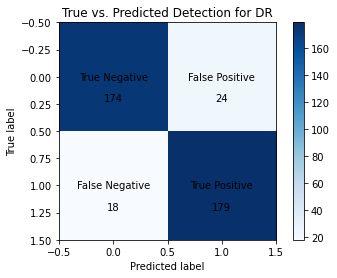

<Figure size 576x576 with 0 Axes>

              precision    recall  f1-score   support

    Negative       0.91      0.88      0.89       198
    Positive       0.88      0.91      0.89       197

    accuracy                           0.89       395
   macro avg       0.89      0.89      0.89       395
weighted avg       0.89      0.89      0.89       395



In [ ]:
from sklearn.metrics import classification_report

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Use the 'Greens' colormap
plt.imshow(cm, cmap='Blues')

# Define the labels for the cells
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Add labels to the cells
for i in range(2):
  for j in range(2):
    plt.text(j, i, labels[2 * i + j], ha='center', va='center', color='black')

# Add the actual numbers to the cells
for i in range(2):
  for j in range(2):
    plt.text(j, i + 0.2, cm[i, j], ha='center', va='center', color='black')

# Adjust the axis labels and title
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('True vs. Predicted Detection for DR')

# Adjust the figure size
plt.figure(figsize=(8, 8))

# Display the plot
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

# ROC Curve

13/13 [==============================] - 0s 16ms/step


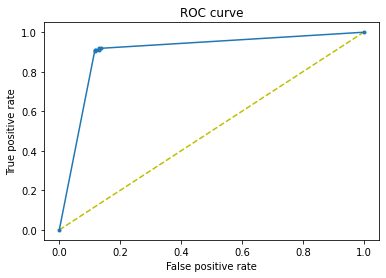

0.8994513664564426


In [ ]:
# ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_preds)
print(auc)

# Learning Curve

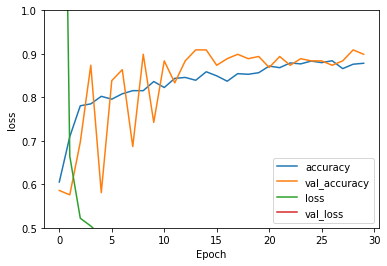

In [ ]:
# Learning Curve and Loss Curve:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Model Architecture


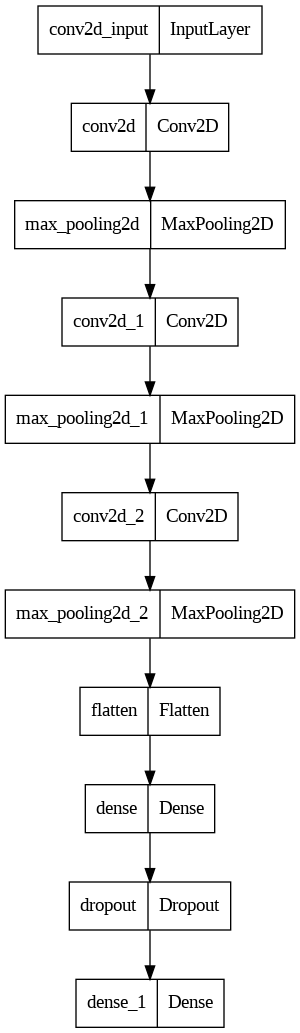

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png')

# TensorBoard

In [ ]:
%tensorboard --logdir logs

# Analyzing Filters


conv2d (3, 3, 3, 32)
32


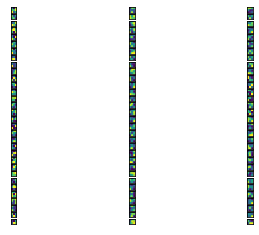

conv2d_1 (3, 3, 32, 64)
64


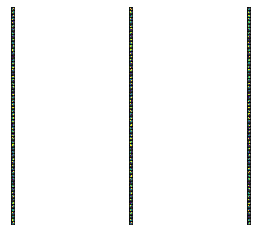

conv2d_2 (3, 3, 64, 64)
64


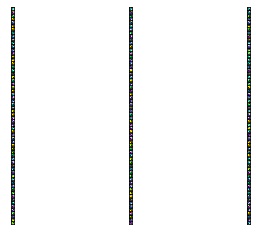

In [ ]:
#Visualizing the filters
#plt.figure(figsize=(5,5))
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(weights.shape[3])
        filter_cnt=1
        #plotting all the filters
        for i in range(filters.shape[3]):
        #for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting ecah channel
            for j in range(filters.shape[0]):
                #plt.figure( figsize=(5, 5) )
                #f = plt.figure(figsize=(10,10))
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

# Analyzing Features

1/1 [==============================] - 0s 427ms/step
(1, 111, 111, 32)
(1, 109, 109, 64)


<ipython-input-19-3b27e2148da1>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


(1, 54, 54, 64)
(1, 52, 52, 64)
(1, 26, 26, 64)
(1, 43264)
(1, 128)
(1, 128)
(1, 1)


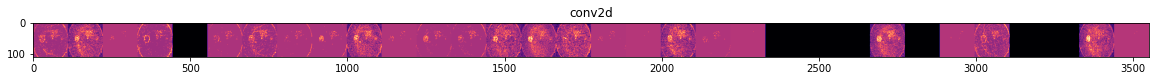

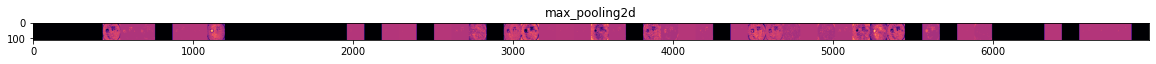

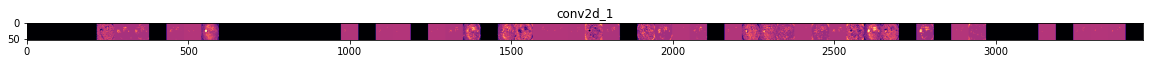

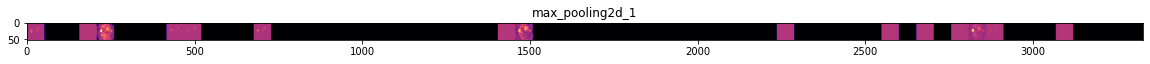

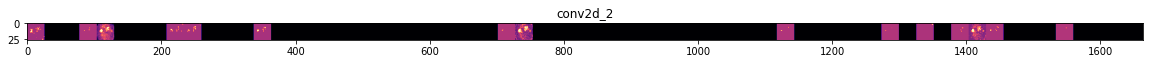

In [ ]:
# Necessary imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

img_path='/content/yes.jpg'
# Define a new Model, Input= image
# Output= intermediate representations for all layers in the
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(224, 224))
# Convert ht image to Array of dimension (224,224,3)
x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:

    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='magma' )

# TensorFlow Lite Implementation -- Android App


In [ ]:
# Convert Model to TensorFlow Lite -- App Usage -- DO NOT RUN THIS EVERYTIME

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Test the TensorFlow Lite Model

img = cv2.imread("yes.jpg")
img = cv2.resize(img, (224,224))
img = np.array(img, dtype="float32")
img = np.reshape(img, (1,224,224,3))

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)